TODO:

* Add loc tokens to tokenizer
* Resize tokenizer and embedding
* Train embedding
* Train using LoRA (check config values)
* Change attention to eager

## Setup and Imports

In [1]:
!nvidia-smi

Thu Apr 24 15:28:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             52W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
! pip install -U -q transformers
! pip install -U -q accelerate
! pip install -U -q datasets
! pip install -U -q matplotlib
! pip install -U -q huggingface_hub[hf_xet]
! pip install -U -q bitsandbytes
! pip install -U -q wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
from huggingface_hub import login

login()

## config.py

In [2]:
from dataclasses import dataclass
import torch

@dataclass
class Configuration:
    dataset_id: str = "ariG23498/license-detection-paligemma"

    model_id: str = "google/gemma-3-4b-pt"
    pg2_id: str = "google/paligemma2-3b-mix-448"

    device: str = "cuda"
    dtype: torch.dtype = torch.bfloat16

    batch_size: int = 2 # 4 for embeddings - 2 for LoRA
    #learning_rate: float = 1e-5
    learning_rate: float = 2e-05

# utils.py

In [3]:
import re
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def parse_paligemma_label(label, width, height):
    # Extract location codes
    loc_pattern = r'<loc(\d{4})>'
    locations = [int(loc) for loc in re.findall(loc_pattern, label)]

    # Extract category (everything after the last location code)
    category = label.split('>')[-1].strip()

    # Convert normalized locations back to original image coordinates
    # Order in PaliGemma format is: y1, x1, y2, x2
    y1_norm, x1_norm, y2_norm, x2_norm = locations

    # Convert normalized coordinates to actual coordinates
    x1 = (x1_norm / 1024) * width
    y1 = (y1_norm / 1024) * height
    x2 = (x2_norm / 1024) * width
    y2 = (y2_norm / 1024) * height

    return category, [x1, y1, x2, y2]


def visualize_bounding_boxes(image, label, width, height, name):
    # Create a copy of the image to draw on
    draw_image = image.copy()
    draw = ImageDraw.Draw(draw_image)

    # Parse the label
    category, bbox = parse_paligemma_label(label, width, height)

    # Draw the bounding box
    draw.rectangle(bbox, outline='red', width=2)

    # Add category label
    draw.text((bbox[0], max(0, bbox[1]-10)), category, fill='red')

    # Show the image
    plt.figure(figsize=(10, 6))
    plt.imshow(draw_image)
    plt.axis('off')
    plt.title(f'Bounding Box: {category}')
    plt.tight_layout()
    plt.show()
    plt.savefig(name)

In [4]:
def train_collate_fn(batch_of_samples, processor, dtype):
    images = []
    prompts = []
    for sample in batch_of_samples:
        images.append([sample["image"]])
        prompts.append(f'{processor.tokenizer.boi_token} detect \n\n{sample["label_for_paligemma"]} {processor.tokenizer.eos_token}')

    batch = processor(images=images, text=prompts, return_tensors="pt", padding=True)

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch["input_ids"].clone()  # Clone input IDs for labels

    # Mask tokens for not being used in the loss computation
    #labels[labels == processor.tokenizer.pad_token_id] = -100
    #labels[labels == processor.tokenizer.boi_token_id] = -100
    #labels[labels == processor.tokenizer.eoi_token_id] = -100
    #labels[labels == processor.tokenizer.image_token_id] = -100

    # Mask image tokens
    image_token_id = [
        processor.tokenizer.convert_tokens_to_ids(processor.tokenizer.special_tokens_map["boi_token"])
    ]
    # Mask tokens for not being used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    labels[labels == 262144] = -100


    batch["labels"] = labels

    batch["pixel_values"] = batch["pixel_values"].to(dtype) # to check with the implementation
    return batch

def test_collate_fn(batch_of_samples, processor, dtype):
    images = []
    prompts = []
    for sample in batch_of_samples:
        images.append([sample["image"]])
        prompts.append(f'{processor.tokenizer.boi_token} detect \n\n')

    batch = processor(images=images, text=prompts, return_tensors="pt", padding=True)
    batch["pixel_values"] = batch["pixel_values"].to(dtype) # to check with the implementation
    return batch, images

# Gemma 3 OD LoRA

In [5]:
import os
from transformers import (
    AutoProcessor,
    AutoTokenizer,
    Gemma3ForConditionalGeneration,
)
from datasets import load_dataset

import torch
from torch.utils.data import DataLoader
from functools import partial

from peft import LoraConfig, get_peft_model, PeftType

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


len(train_dataset)=6176
len(val_dataset)=1765
len(test_dataset)=882


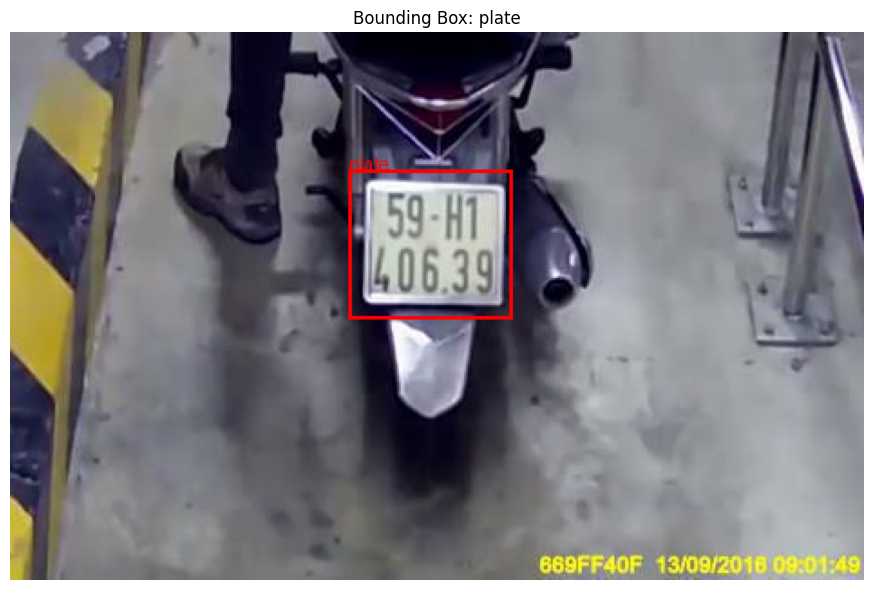

<Figure size 640x480 with 0 Axes>

In [6]:
cfg = Configuration()

train_dataset = load_dataset(cfg.dataset_id, split="train")
val_dataset = load_dataset(cfg.dataset_id, split="validation")
test_dataset = load_dataset(cfg.dataset_id, split="test")

print(f"{len(train_dataset)=}")
print(f"{len(val_dataset)=}")
print(f"{len(test_dataset)=}")

dir_name = "outputs_lora"
os.makedirs(dir_name, exist_ok=True)

data_sample = train_dataset[-100] # choose any other index to play around
visualize_bounding_boxes(
    data_sample["image"],
    data_sample["label_for_paligemma"],
    data_sample["width"],
    data_sample["height"],
    f"{dir_name}/sample.png"
)

In [7]:
processor = AutoProcessor.from_pretrained(cfg.model_id)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [8]:
pg2_tok = AutoTokenizer.from_pretrained(cfg.pg2_id)
g3_tok = AutoTokenizer.from_pretrained(cfg.model_id)

location_tokens = []

values = list(pg2_tok.added_tokens_decoder.values())
for v in values:
    if "<loc" in v.content:
        location_tokens.append(v.content)

g3_tok.add_tokens(location_tokens)
processor.tokenizer = g3_tok

In [ ]:
train_collate_fn = partial(train_collate_fn, processor=processor, dtype=cfg.dtype)
test_collate_fn = partial(test_collate_fn, processor=processor, dtype=cfg.dtype)

train_dataloader = DataLoader(train_dataset, batch_size=cfg.batch_size, collate_fn=train_collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=cfg.batch_size, collate_fn=train_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=cfg.batch_size, collate_fn=test_collate_fn)

In [12]:
model = Gemma3ForConditionalGeneration.from_pretrained(
    cfg.model_id,
    torch_dtype=cfg.dtype,
    # device_map=cfg.device,
    # attn_implementation="eager", # As Sergio points out
)

config.json:   0%|          | 0.00/815 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

# Normal training over the embeddings

In [13]:
model.resize_token_embeddings(len(processor.tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Gemma3TextScaledWordEmbedding(263169, 2560, padding_idx=0)

In [10]:
import wandb

wandb.init(project="g3-od-lora")

wandb: Currently logged in as: sergiopaniego to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [16]:
model.to(cfg.device)

# Freeze everything but the embeddings
for param in model.parameters():
    param.requires_grad = False

# Only train embeddings
for name, param in model.named_parameters():
    if 'embeddings' in name:
        param.requires_grad = True

# Optimizer config
optimizer = torch.optim.AdamW(model.get_input_embeddings().parameters(), lr=1e-5)

# Embeddings training
for epoch in range(1):
    for idx, batch in enumerate(train_dataloader):
        outputs = model(**batch.to(cfg.device))
        loss = outputs.loss
        wandb.log({"loss_embeddings": loss.item(), "epoch": epoch, "step": idx})
        if idx % 100 == 0:
            print(f"Epoch: {epoch} Iter: {idx} Loss: {loss.item():.4f}")
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch} - Loss: {loss.item():.4f}")

Epoch: 0 Iter: 0 Loss: 10.4896
Epoch: 0 Iter: 100 Loss: 10.5095
Epoch: 0 Iter: 200 Loss: 10.8541
Epoch: 0 Iter: 300 Loss: 10.6193
Epoch: 0 Iter: 400 Loss: 10.5630
Epoch: 0 Iter: 500 Loss: 11.3602
Epoch: 0 Iter: 600 Loss: 10.7793
Epoch: 0 Iter: 700 Loss: 10.4294
Epoch: 0 Iter: 800 Loss: 10.4988
Epoch: 0 Iter: 900 Loss: 10.3244
Epoch: 0 Iter: 1000 Loss: 10.4511
Epoch: 0 Iter: 1100 Loss: 10.4847
Epoch: 0 Iter: 1200 Loss: 10.4874
Epoch: 0 Iter: 1300 Loss: 10.5259
Epoch: 0 Iter: 1400 Loss: 10.6527
Epoch: 0 Iter: 1500 Loss: 10.4783
Epoch 0 - Loss: 10.5601


In [17]:
model.save_pretrained("g3-od-lora")
processor.save_pretrained("g3-od-lora")

['g3-od-lora/processor_config.json']

# LoRA training over the whole model

In [8]:
model = Gemma3ForConditionalGeneration.from_pretrained(
    "g3-od-lora",
    torch_dtype=cfg.dtype,
)
processor = AutoProcessor.from_pretrained("g3-od-lora")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [9]:
train_collate_fn = partial(train_collate_fn, processor=processor, dtype=cfg.dtype)
test_collate_fn = partial(test_collate_fn, processor=processor, dtype=cfg.dtype)

train_dataloader = DataLoader(train_dataset, batch_size=cfg.batch_size, collate_fn=train_collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=cfg.batch_size, collate_fn=train_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=cfg.batch_size, collate_fn=test_collate_fn)

In [11]:
model.requires_grad_(False) # We freeze the model since we're training the LoRA adapter

Gemma3ForConditionalGeneration(
  (vision_tower): SiglipVisionModel(
    (vision_model): SiglipVisionTransformer(
      (embeddings): SiglipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(4096, 1152)
      )
      (encoder): SiglipEncoder(
        (layers): ModuleList(
          (0-26): 27 x SiglipEncoderLayer(
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (self_attn): SiglipAttention(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm2): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): SiglipMLP(
            

In [12]:
for name, module in model.named_modules():
    print(name)


vision_tower
vision_tower.vision_model
vision_tower.vision_model.embeddings
vision_tower.vision_model.embeddings.patch_embedding
vision_tower.vision_model.embeddings.position_embedding
vision_tower.vision_model.encoder
vision_tower.vision_model.encoder.layers
vision_tower.vision_model.encoder.layers.0
vision_tower.vision_model.encoder.layers.0.layer_norm1
vision_tower.vision_model.encoder.layers.0.self_attn
vision_tower.vision_model.encoder.layers.0.self_attn.k_proj
vision_tower.vision_model.encoder.layers.0.self_attn.v_proj
vision_tower.vision_model.encoder.layers.0.self_attn.q_proj
vision_tower.vision_model.encoder.layers.0.self_attn.out_proj
vision_tower.vision_model.encoder.layers.0.layer_norm2
vision_tower.vision_model.encoder.layers.0.mlp
vision_tower.vision_model.encoder.layers.0.mlp.activation_fn
vision_tower.vision_model.encoder.layers.0.mlp.fc1
vision_tower.vision_model.encoder.layers.0.mlp.fc2
vision_tower.vision_model.encoder.layers.1
vision_tower.vision_model.encoder.laye

In [13]:
lora_config = LoraConfig(
    inference_mode=False,                 # <- Required for training
    r=8,                                  # <- LoRA rank dimension (lower = more efficient, higher = more capacity)
    lora_alpha=32,                        # <- LoRA scaling factor (usually 1-4x the value of r)
    lora_dropout=0.1,                     # <- Dropout applied between LoRA projections
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"], #["q_proj", "v_proj"],  # ["all_linear"] ?? # <- Important: modules to be modified
    peft_type=PeftType.LORA,
)

lora_model = get_peft_model(model=model, peft_config=lora_config).to(cfg.device)
lora_model.print_trainable_parameters()

trainable params: 5,949,440 || all params: 4,308,489,072 || trainable%: 0.1381


In [14]:
sample, sample_images = next(iter(test_dataloader))
sample = sample.to(cfg.device)
for key, value in sample.items():
    print(key, value.dtype, value.device)

input_ids torch.int64 cuda:0
attention_mask torch.int64 cuda:0
token_type_ids torch.int64 cuda:0
pixel_values torch.bfloat16 cuda:0


In [15]:
params_to_train = list(filter(lambda x: x.requires_grad, lora_model.parameters())) # Note!
optimizer = torch.optim.AdamW(params_to_train, lr=cfg.learning_rate)

In [ ]:
for epoch in range(1):
    for idx, batch in enumerate(train_dataloader):
        outputs = lora_model(**batch.to(cfg.device))
        loss = outputs.loss

        wandb.log({"loss_lora": loss.item(), "epoch": epoch, "step": idx})

        if idx % 100 == 0:
            print(f"Epoch: {epoch} Iter: {idx} Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

Epoch: 0 Iter: 0 Loss: 10.4206
Epoch: 0 Iter: 100 Loss: 4.8645


In [ ]:
wandb.finish()

In [ ]:
merged_model = lora_model.merge_and_unload()
merged_model.push_to_hub("sergiopaniego/g3-od-lora")
processor.push_to_hub("sergiopaniego/g3-od-lora")

merged_model.eval()
generation = merged_model.generate(**sample, max_new_tokens=100)
decoded = processor.batch_decode(generation, skip_special_tokens=True)

file_count = 0
for output_text, sample_image in zip(decoded, sample_images):
    im = sample_image[0]
    width, height = im.size
    visualize_bounding_boxes(im, output_text, width, height, f"{dir_name}/output_{file_count}.png")
    file_count += 1